# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-lc'
epochs = 10
batch_size = 4
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=192, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6016, Accuracy: 0.8285, F1 Micro: 0.8825, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4016, Accuracy: 0.9503, F1 Micro: 0.9625, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3298, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2995, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2195, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2396

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5078, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3113, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.236, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1912, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.185, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1634, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1326, Accuracy: 0.9567, F1 Micro: 0.9672

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1942, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2264, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3961, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1449, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1392, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1098, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7344
Epoch 9/10, Train Loss: 0.0934, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1631, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Epoch 10/10, Train Loss: 0.0545, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1906, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.8303
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8025
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3312, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2114, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1676, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1203, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7264
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8278
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8319
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8295
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.8167
Epoch 10/10, Train Loss: 0.0338, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3114, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0788, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.82
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8101
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.961

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3066, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1892, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0995, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7459
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7637
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Epoch 10/10, Train Loss: 0.0453, Accuracy: 0.9647, F1 Micro: 0.9732, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.301, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3088, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.135, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7533
Epoch 5/10, Train Loss: 0.1026, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8209
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8207
Epoch 10/10, Train Loss: 0.037, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2809, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7392
Epoch 6/10, Train Loss: 0.0733, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8214
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2554, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7568
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7027
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.8186
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7882
Epoch 10/10, Train Loss: 0.0314, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.286, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1761, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1218, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7319
Epoch 6/10, Train Loss: 0.0749, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Epoch 10/10, Train Loss: 0.0256, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2759, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.191, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1462, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.82
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2657, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1489, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.156, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1078, Accuracy: 0.9471, F1 Micro: 0.9605, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0875, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0475, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7434
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7459
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2542, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1638, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 4/10, Train Loss: 0.1051, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.101, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7953
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.752
Epoch 10/10, Train Loss: 0.0338, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2469, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.146, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.141, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 4/10, Train Loss: 0.1119, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.0812, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7299
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8105
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7393
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2362, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1404, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1072, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.755
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7426
Epoch 6/10, Train Loss: 0.052, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6962
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8197
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.8102
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0223, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2456, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1464, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1362, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1089, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 5/10, Train Loss: 0.0779, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7428
Epoch 6/10, Train Loss: 0.0562, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8028
Epoch 8/10, Train Loss: 0.0298, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.7915
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7468
Epoch 10/10, Train Loss: 0.0246, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8105
Iteration 370: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2461, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1148, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0899, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.0634, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0567, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Epoch 8/10, Train Loss: 0.0434, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7973
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Epoch 10/10, Train Loss: 0.0189, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8049
Iteration 380: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2479, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1546, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1418, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1192, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 5/10, Train Loss: 0.0736, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Epoch 6/10, Train Loss: 0.0504, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7526
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7864
Epoch 8/10, Train Loss: 0.0429, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.82
Epoch 9/10, Train Loss: 0.0259, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8187
Iteration 390: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.244, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.141, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 4/10, Train Loss: 0.1211, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 5/10, Train Loss: 0.0882, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.736
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Epoch 9/10, Train Loss: 0.0268, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.8098
Epoch 10/10, Train Loss: 0.0236, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.7915
Iteration 400: Accuracy: 0.9647, F1 Micro: 0.9728, F1 M

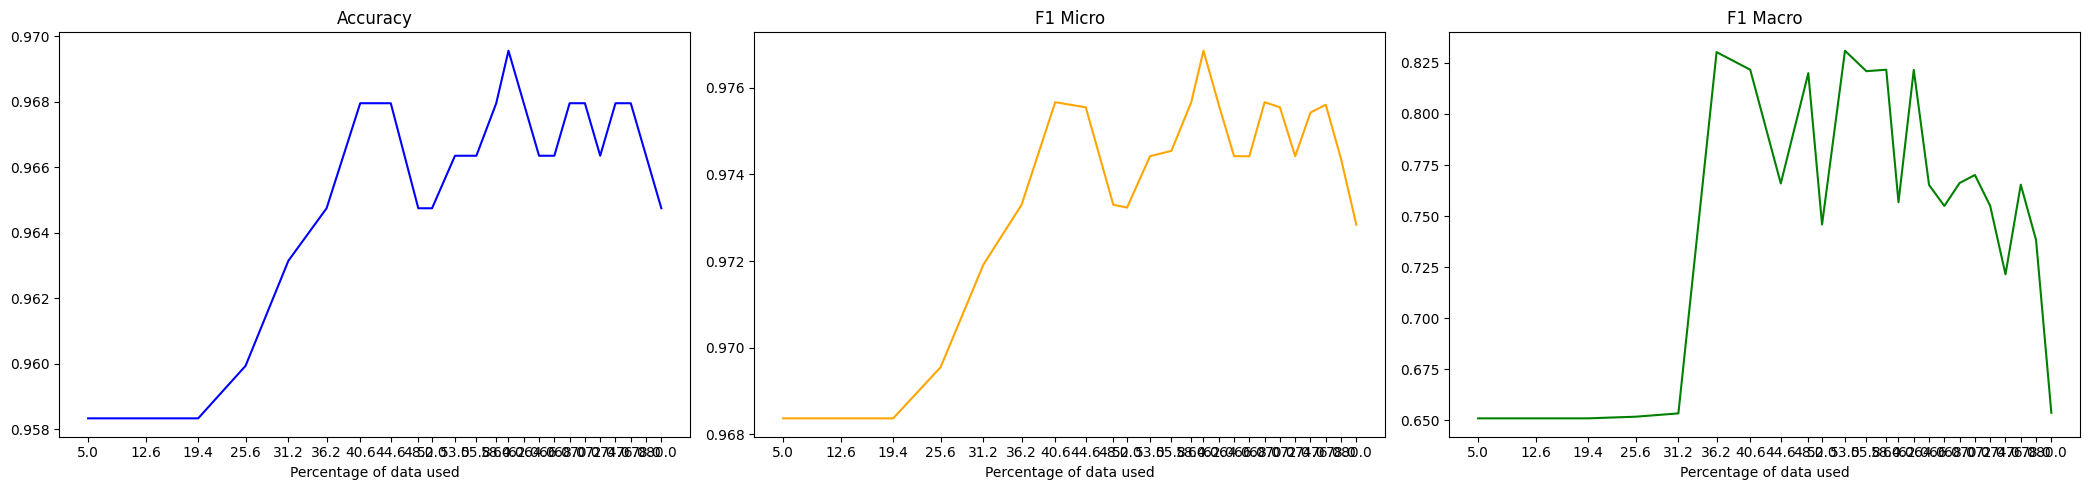

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6111, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3439, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1214, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1431, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5004, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2085, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1265, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1303,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4095, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1132, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2005, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.109, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.6502
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6507
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1024, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 10/10, Train Loss: 0.0561, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3357, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2063, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2093, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6516
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7189
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2052, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7345
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7635
Epoch 10/10, Train Loss: 0.0391, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3012, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1849, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7939
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7354
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3087, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7296
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7455
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2954, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1885, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7435
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8317
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7375
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3065, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1973, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7646
Epoch 5/10, Train Loss: 0.0947, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0686, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8036
Epoch 7/10, Train Loss: 0.0581, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.8015
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8022
Epoch 9/10, Train Loss: 0.0313, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8194
Epoch 10/10, Train Loss: 0.0241, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2853, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.0982, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6947
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8109
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8108
Epoch 10/10, Train Loss: 0.0278, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2868, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8217
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8105
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8214
Epoch 10/10, Train Loss: 0.0276, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2858, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7551
Epoch 6/10, Train Loss: 0.0643, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8028
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.269, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1844, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1196, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7442
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.805
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8119
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8057
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0228, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2735, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1801, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1112, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7636
Epoch 5/10, Train Loss: 0.0868, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 6/10, Train Loss: 0.0583, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0438, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2667, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1603, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0765, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Epoch 7/10, Train Loss: 0.0437, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8048
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9631, F1 Micro: 0.9721, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.268, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.14, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0867, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0646, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8025
Epoch 8/10, Train Loss: 0.0393, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.256, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1126, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.104, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.0613, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8214
Epoch 8/10, Train Loss: 0.0327, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7548
Epoch 9/10, Train Loss: 0.0259, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0205, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1529, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.147, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1097, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7466
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0843, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.8118
Epoch 7/10, Train Loss: 0.0526, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8116
Epoch 8/10, Train Loss: 0.0311, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8124
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2487, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.114, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0798, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0552, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8124
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8196
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0249, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2455, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1396, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7452
Epoch 5/10, Train Loss: 0.0883, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7365
Epoch 6/10, Train Loss: 0.0505, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0444, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8049
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.8015
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8325
Epoch 10/10, Train Loss: 0.027, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2466, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1794, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1493, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1158, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Epoch 5/10, Train Loss: 0.0782, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6937
Epoch 6/10, Train Loss: 0.0559, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0404, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8116
Epoch 8/10, Train Loss: 0.0318, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7424
Epoch 9/10, Train Loss: 0.0227, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0229, Accuracy:

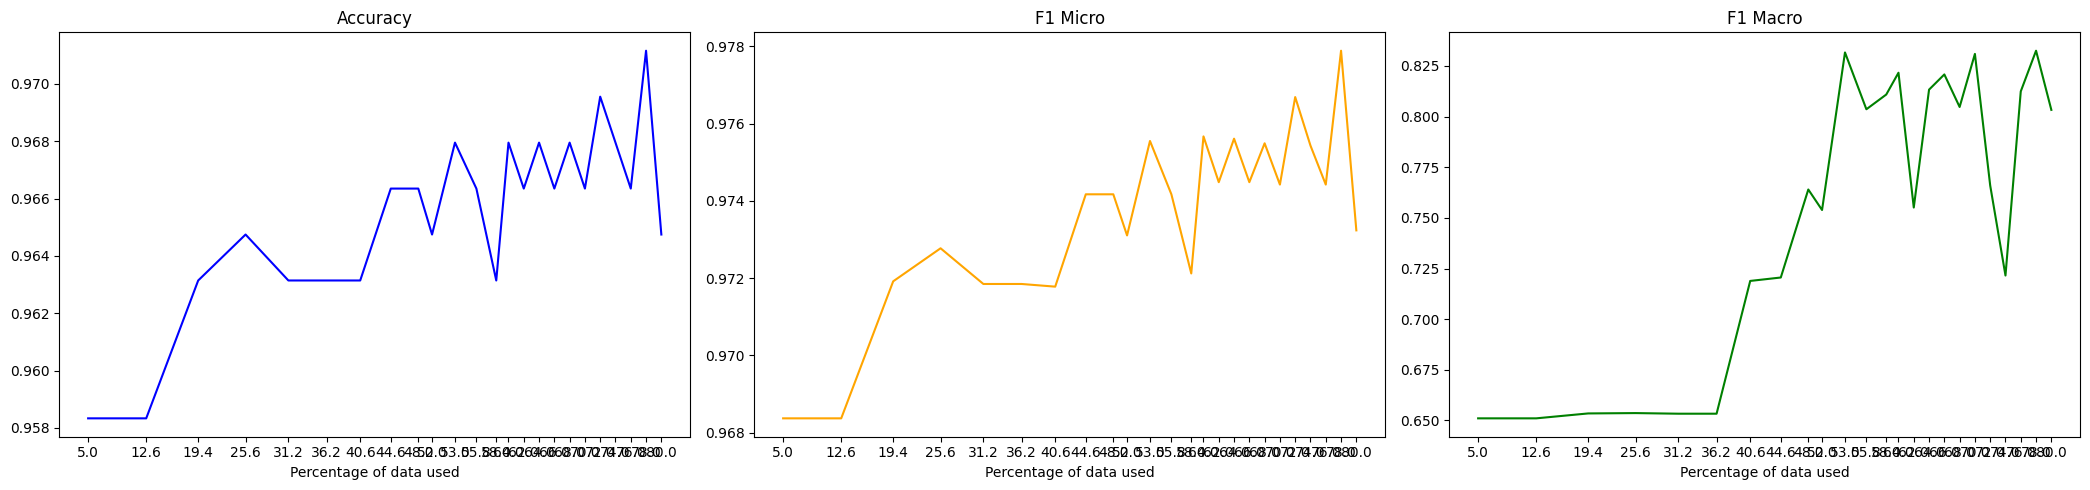

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5548, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3193, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2116, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2102, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1485, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1127, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0838,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4799, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2096, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1278, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1352, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1214,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3872, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.086

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 10/10, Train Loss: 0.0602, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3221, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1994, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.141, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1383, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9535, F1 Micro: 0.9635, F1 Macro: 0.6455
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7187
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1573, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9551, F1 Micro: 0.9648, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7637
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7629
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3221, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.192, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.8136
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9696, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7082
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7932
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7924
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0366, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2884, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1886, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1597, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8308
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8295
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 10/10, Train Loss: 0.0338, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2846, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8293
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2825, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1755, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0555, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2832, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7476
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7223
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8325
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9712, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7512
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7669
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.75
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8317
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Epoch 5/10, Train Loss: 0.1042, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0718, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8192
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2655, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.9551, F1 Micro: 0.9649, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0741, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7892
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.789
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7234
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8214
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0833, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 8/10, Train Loss: 0.0383, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0218, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2639, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 5/10, Train Loss: 0.0881, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 6/10, Train Loss: 0.0494, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.8315
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8029
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2548, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1649, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1534, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0573, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7864
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0324, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8032
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2494, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1667, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 6/10, Train Loss: 0.0639, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8056
Epoch 9/10, Train Loss: 0.0271, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7881
Epoch 10/10, Train Loss: 0.0256, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2447, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1726, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0972, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7022
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0646, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7567
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7027
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7451
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2349, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1471, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1095, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0817, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7476
Epoch 6/10, Train Loss: 0.0557, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 7/10, Train Loss: 0.0374, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 10/10, Train Loss: 0.0172, Accuracy: 0.9663, F1 Micro: 0.9744, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2382, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1531, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0904, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0657, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8214
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7827
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2316, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 3/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1019, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0836, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0607, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7872
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9696, F1 Micro: 0.9765, F1 Macro: 0.7222
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8213
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2432, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1408, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1207, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0887, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.8175
Epoch 6/10, Train Loss: 0.0672, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8189
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7532
Epoch 10/

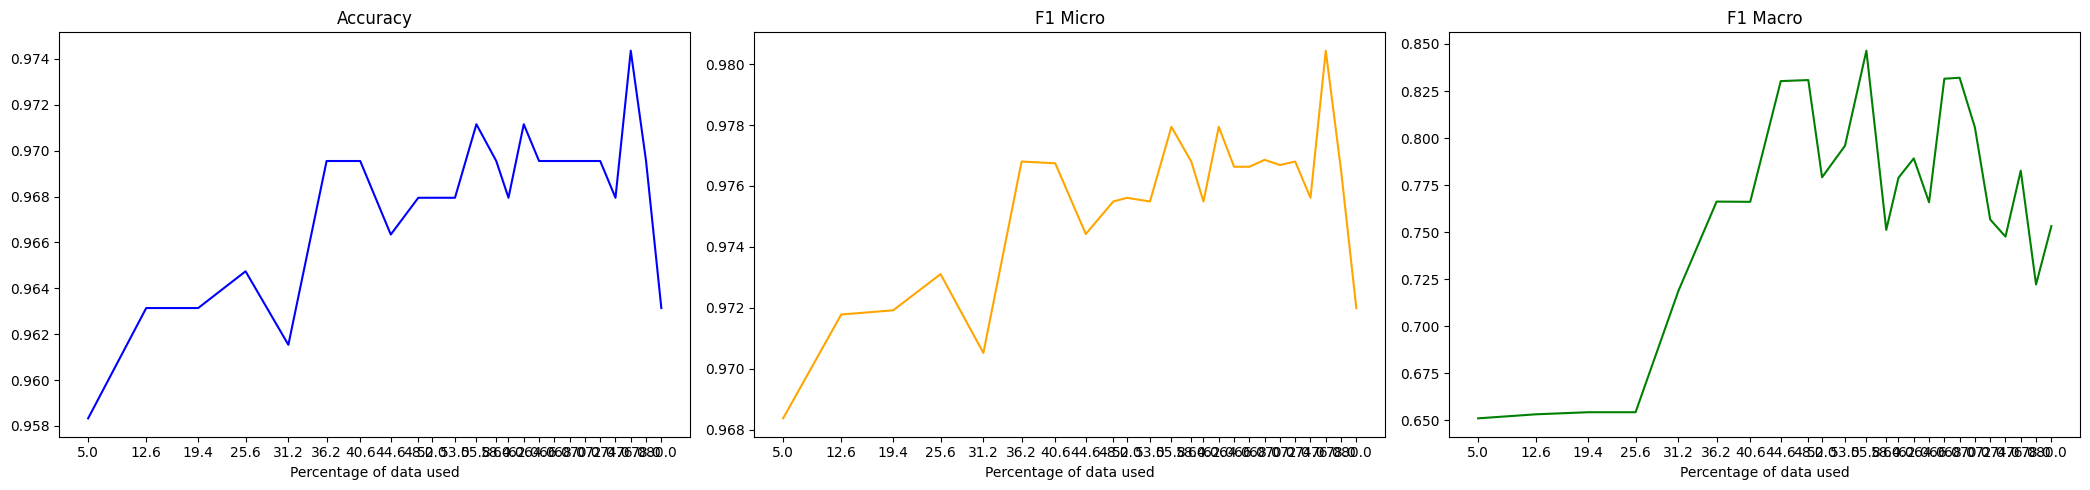

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5287, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3283, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.216, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2059, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1983, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.123, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1667, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4266, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1541, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1547, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1155, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2076, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1836, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1603, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6491
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.9535, F1 Micro: 0.9643, F1 Macro: 0.6475
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3333, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1462, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9551, F1 Micro: 0.9657, F1 Macro: 0.6487
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 10/10, Train Loss: 0.0665, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3054, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1624, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 7/10, Train Loss: 0.1301, Accuracy: 0.9519, F1 Micro: 0.9632, F1 Macro: 0.6469
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9535, F1 Micro: 0.9645, F1 Macro: 0.6479
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9551, F1 Micro: 0.9658, F1 Macro: 0.6489
Epoch 10/10, Train Loss: 0.0559, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1982, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9535, F1 Micro: 0.9644, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9535, F1 Micro: 0.9644, F1 Macro: 0.6477
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9551, F1 Micro: 0.9657, F1 Macro: 0.6487
Epoch 10/10, Train Loss: 0.054, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2934, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10, Train Loss: 0.0368, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1794, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Epoch 10/10, Train Loss: 0.033, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2652, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 5/10, Train Loss: 0.1053, Accuracy: 0.9455, F1 Micro: 0.9593, F1 Macro: 0.7066
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8607
Epoch 10/10, Train Loss: 0.0278, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.265, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1702, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1313, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1074, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.843
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.8169
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7931
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9663, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2499, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2002, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.105, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8448
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.024, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.25, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7628
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9615, F1 Micro: 0.9701, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.842
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8412
Iteration 300: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1757, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7525
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.829
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8196
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0251, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1596, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.102, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Epoch 6/10, Train Loss: 0.0774, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2477, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1504, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1277, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7187
Epoch 6/10, Train Loss: 0.0659, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8105
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8106
Epoch 9/10, Train Loss: 0.0271, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7362
Epoch 10/10, Train Loss: 0.0191, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2295, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0985, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.073, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.83
Epoch 7/10, Train Loss: 0.051, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7934
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9663, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2372, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0963, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.8453
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9696, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2282, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1683, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1172, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 6/10, Train Loss: 0.0763, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7307
Epoch 7/10, Train Loss: 0.0497, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8179
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2322, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1184, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.1026, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7967
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7959
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2278, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0968, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7657
Epoch 6/10, Train Loss: 0.073, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8285
Epoch 7/10, Train Loss: 0.0496, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8298
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0209, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2281, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1503, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1161, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7376
Epoch 5/10, Train Loss: 0.0799, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.0451, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0312, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8115
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2279, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1744, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 5/10, Train Loss: 0.0867, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7315
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9567, F1 Micro: 0.9675, F1 Macro: 0.7954
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.79
Epoch 9/10, Train Loss: 0.0243, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.8014
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0174, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro

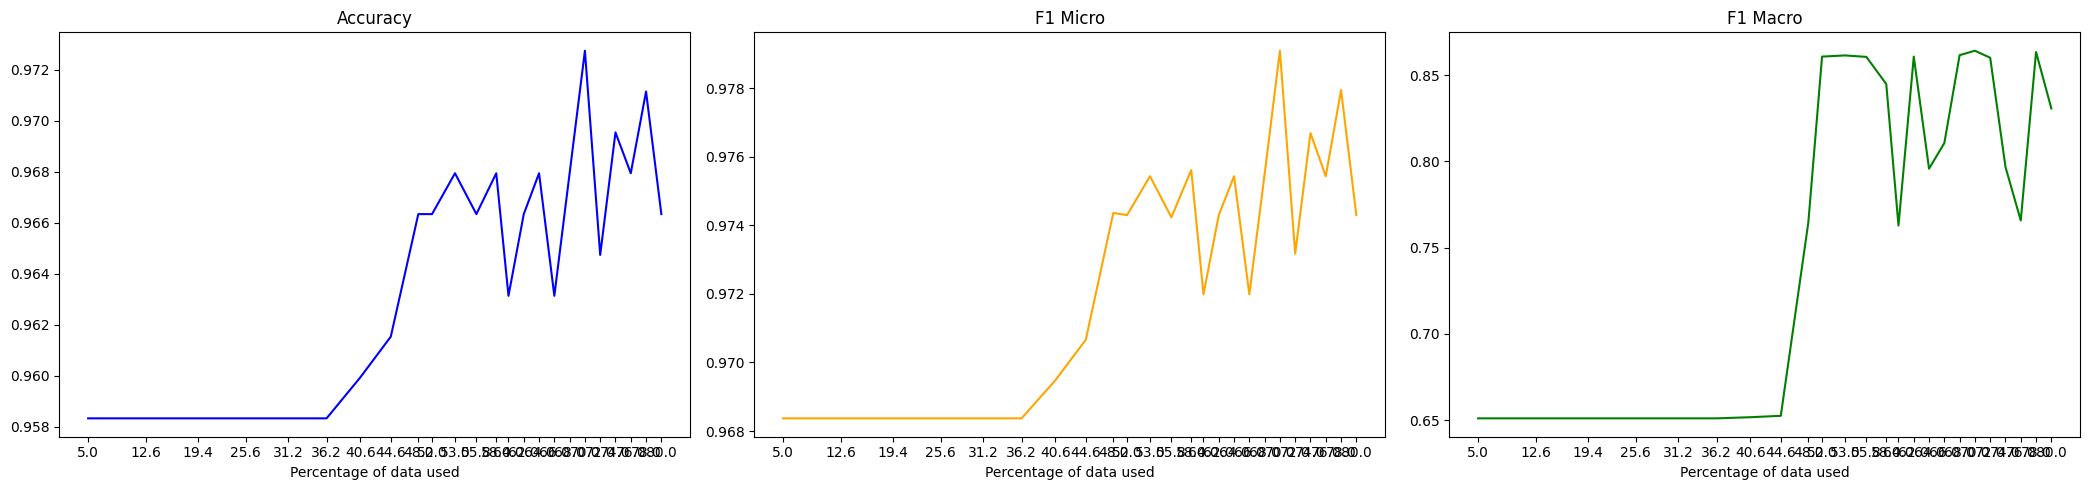

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3082, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1278, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1663, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.487, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2376, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1346, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.128, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.123, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2373, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1473, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1236, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3544, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1436, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1166, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1123, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.9599, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0745, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3269, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1946, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9647, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2928, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1931, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8093
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7517
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2866, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2064, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7201
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7352
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7636
Epoch 10/10, Train Loss: 0.0306, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2871, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7959
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7952
Epoch 10/10, Train Loss: 0.0311, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2796, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9679, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1822, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7629
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7955
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.83
Epoch 10/10, Train Loss: 0.0319, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7962
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7962
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9679, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2598, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1584, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7257
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.738
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7637
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1753, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1274, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7966
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8105
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2456, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.135, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1028, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7668
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8094
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7541
Epoch 10/10, Train Loss: 0.0246, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2447, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1547, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1131, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7567
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7526
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7632
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7635
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8308
Iteration 320: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.166, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.767
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0438, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.021, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2477, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1409, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7495
Epoch 5/10, Train Loss: 0.1057, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7526
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7445
Epoch 7/10, Train Loss: 0.0474, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.034, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7533
Epoch 9/10, Train Loss: 0.0248, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7522
Iteration 340: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1466, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0904, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 6/10, Train Loss: 0.0688, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0237, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Epoch 10/10, Train Loss: 0.0272, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2411, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1624, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1251, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7801
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7636
Epoch 6/10, Train Loss: 0.0734, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.796
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7512
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.83
Iteration 360: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2195, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1148, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7545
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0477, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.031, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8198
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2378, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1429, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1298, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1278, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1038, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7639
Epoch 6/10, Train Loss: 0.0728, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Epoch 7/10, Train Loss: 0.0402, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0301, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0227, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2299, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 3/10, Train Loss: 0.1429, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 4/10, Train Loss: 0.1251, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0938, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Epoch 10/10, Train Loss: 0.0222, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8198
Iteration 390: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2355, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1368, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1236, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.088, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7647
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8096
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8318
Epoch 10/10, Train Loss: 0.023, Accuracy: 0.

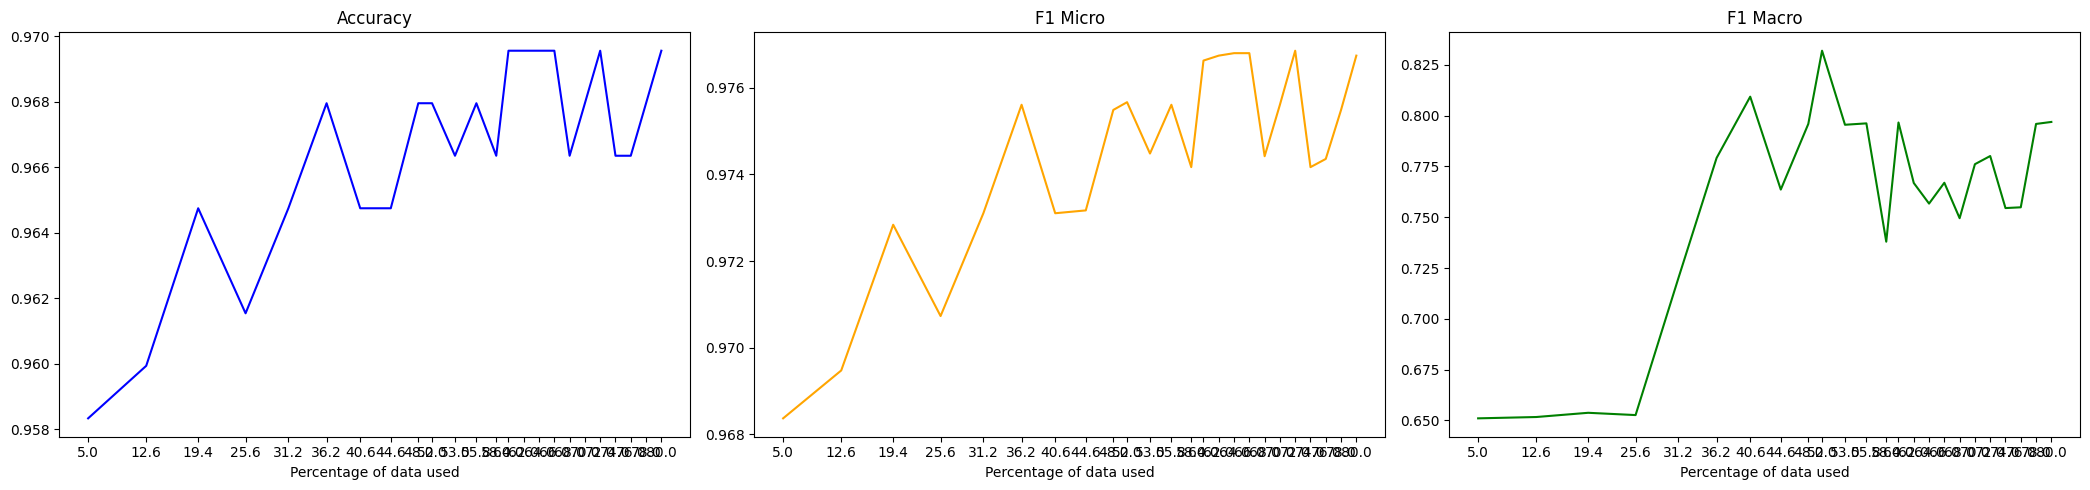

In [ ]:
active_learning(seeds[4], 4)